# Introducing Tensorflow


In [1]:
import tensorflow as tf

a = tf.Variable(1, name="a")
b = tf.Variable(2, name="b")
f = a + b

tf.print(f)

3


2022-01-12 13:38:19.554109: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-12 13:38:19.555743: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-12 13:38:19.559216: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
#Prepare MNIST data

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

num_classes = 10 # (0-9 digits)
num_features = 784 # data features (img shape: 28x28)

(x_train, y_train), (x_test, y_test) = mnist.load_data() #60.000 training, 10.000 testing

#Convert to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

#Flatten images to 1-D Vector of 784 features (28x28)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

#Normalize images value from [0,255] to [0,1]

x_train, x_test = x_train / 255., x_test/255.

11493376/11490434 [==============================] - 2s 0us/step


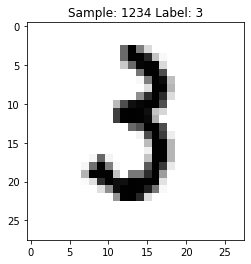

In [3]:
import matplotlib.pyplot as plt

def display_sample(num):
    #Print this sample's label:
    label = y_train[num]

    #Reshape the 784 values to a 28x28 image

    image = x_train[num].reshape([28,28])
    plt.title('Sample: %d Label: %d' %(num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1234)

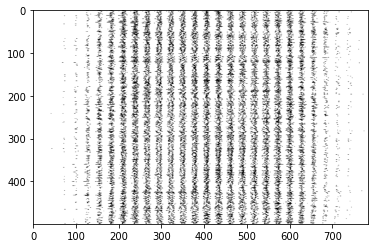

In [4]:
images = x_train[10].reshape([1,784])
for i in range(1,500):
    images = np.concatenate((images,x_train[i].reshape([1,784])))
plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

In [5]:
#Training parameters

learning_rate = 0.001
training_steps = 3000
batch_size = 250 
display_step = 100

#Network parameters

n_hidden = 512 #Number of neurons

In [6]:
train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

In [7]:
#Store layers weight & bias

#A random value generator to initialize weights initially
random_normal = tf.initializers.RandomNormal()

weights = {
    'h': tf.Variable(random_normal([num_features, n_hidden])), #784 features, 512 hidden neurons
    'out':tf.Variable(random_normal([n_hidden, num_classes])) #512 hidden enurons, 10 classes
}

biases = {
    'b':tf.Variable(tf.zeros([n_hidden])),
    'out':tf.Variable(tf.zeros([num_classes]))
}

In [8]:
#Topology

def neural_network(inputData):
    #Hiden fully connected layer with 512 neurons.
    hidden_layer = tf.add(tf.matmul(inputData, weights['h']), biases['b'])
    #Apply sigmoid to hidden layer output for non-linearity.
    hidden_layer= tf.nn.sigmoid(hidden_layer)

    #Output fully connected layer with a neuron for each class.
    out_layer = tf.matmul(hidden_layer, weights['out']) + biases['out']
    #Apply softmax to normalize the logits to a probabability distribution
    return tf.nn.softmax(out_layer)

Make sure you noodle on the above block. This sets up a deep neural network like the one we talked about in our slides.

output layer

hidden layer

input layer

Next we will define our loss function for use in measuring our progress in gradient descent: cross-entropy, which applies a logarithmic scale to penalize incorrect classifications much more than ones that are close. Remember digit_weights is the output of our final layer, and we're comparing that against the target labels used for training.

In [9]:
def cross_entropy(y_pred, y_true):
    #Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    #Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    #Compute cross-entropy
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x,y):
    #Wrap computation inside a GradientTape for automatic differentiation
    with tf.GradientTape() as g:
        pred = neural_network(x)
        loss = cross_entropy(pred, y)
    
    #variaables to update
    trainable_variables = list(weights.values()) + list(biases.values())

    #Compute gradients.
    gradients = g.gradient(loss, trainable_variables)

    #Update W and b following gradients.

    optimizer.apply_gradients(zip(gradients,trainable_variables))

In [11]:
#Accuracy

def accuracy(y_pred, y_true):
    #Predicted class is the index of higest score in prediction vector (i.e. argmax)
    correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [14]:
#Training

#Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    #Run the optimization to update W and b values
    run_optimization(batch_x, batch_y)

    if step % display_step == 0: #Every 100 steps
        pred = neural_network(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("training epoch: %i, Loss: %f, Accuracy: %f" % (step,loss,acc))

training epoch: 100, Loss: 67.907150, Accuracy: 0.904000
training epoch: 200, Loss: 66.021454, Accuracy: 0.940000
training epoch: 300, Loss: 79.663040, Accuracy: 0.900000
training epoch: 400, Loss: 54.676697, Accuracy: 0.928000
training epoch: 500, Loss: 100.618233, Accuracy: 0.900000
training epoch: 600, Loss: 74.593842, Accuracy: 0.916000
training epoch: 700, Loss: 89.262093, Accuracy: 0.888000
training epoch: 800, Loss: 72.056786, Accuracy: 0.924000
training epoch: 900, Loss: 82.110382, Accuracy: 0.920000
training epoch: 1000, Loss: 71.942307, Accuracy: 0.920000
training epoch: 1100, Loss: 51.337044, Accuracy: 0.944000
training epoch: 1200, Loss: 57.136414, Accuracy: 0.916000
training epoch: 1300, Loss: 94.730087, Accuracy: 0.908000
training epoch: 1400, Loss: 54.481010, Accuracy: 0.928000
training epoch: 1500, Loss: 51.989899, Accuracy: 0.952000
training epoch: 1600, Loss: 73.724930, Accuracy: 0.916000
training epoch: 1700, Loss: 61.515194, Accuracy: 0.920000
training epoch: 1800, 

In [15]:
#Test model

pred = neural_network(x_test)
print("Test Accuracy: %f" % accuracy(pred,y_test))

Test Accuracy: 0.935700


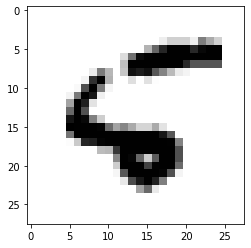

Original labels: 5
Model predictions: 6


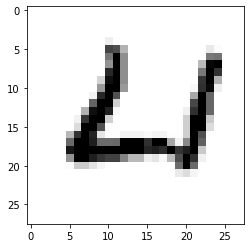

Original labels: 4
Model predictions: 6


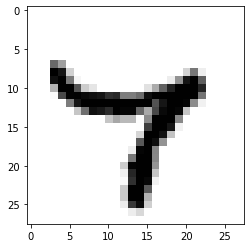

Original labels: 7
Model predictions: 4


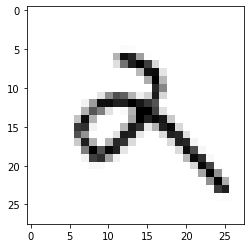

Original labels: 2
Model predictions: 9


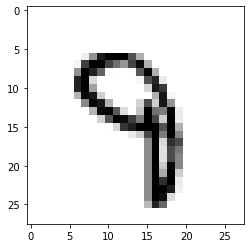

Original labels: 9
Model predictions: 3


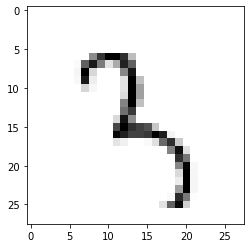

Original labels: 3
Model predictions: 5


In [16]:
n_images = 200
test_images = x_test[:n_images]
test_labels = y_test[:n_images]
predictions = neural_network(test_images)

for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if(model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray_r')
        plt.show()
        print("Original labels: %i" % test_labels[i])
        print("Model predictions: %i" % model_prediction)